# data preparation

In [1]:
import pandas
import numpy

In [2]:
df = pandas.read_csv('../data/df_all_.csv')
df = df[df['previous10'] > 0]

In [3]:
len(df.columns)

19

In [4]:
df.columns

Index(['day', 'time', 'in', 'out', 'passenger', 'S0', 'S1', 'passenger_pt',
       'dtime', 'previous1', 'previous2', 'previous3', 'previous4',
       'previous5', 'previous6', 'previous7', 'previous8', 'previous9',
       'previous10'],
      dtype='object')

In [5]:
y_name = ['passenger']
X_name = ['time', 'S0', 'S1', 'dtime', 'previous1', 'previous2', 'previous3',
       'previous4', 'previous5', 'previous6', 'previous7', 'previous8',
       'previous9', 'previous10']
meta = ['day', 'passenger_pt', 'in', 'out']

In [6]:
# change column order for scaling later
df = df[y_name + X_name + meta]

## train-test split

In [7]:
train_days = 80

train = df[df['day'] < train_days]
test = df[df['day'] >= train_days]

In [8]:
train.head()

,passenger,time,S0,S1,dtime,previous1,previous2,previous3,previous4,previous5,previous6,previous7,previous8,previous9,previous10,day,passenger_pt,in,out
10,1.0,0.97,924.0,76.0,0.01,1.0,2.0,1.0,3.0,4.0,1.0,1.0,1.0,2.0,4.0,0.0,100.000000,1.0,0.0
11,1.0,1.00,919.0,81.0,0.03,1.0,1.0,2.0,1.0,3.0,4.0,1.0,1.0,1.0,2.0,0.0,33.333333,1.0,0.0
12,1.0,1.03,914.0,86.0,0.03,1.0,1.0,1.0,2.0,1.0,3.0,4.0,1.0,1.0,1.0,0.0,33.333333,1.0,0.0
13,1.0,1.09,915.0,85.0,0.06,1.0,1.0,1.0,1.0,2.0,1.0,3.0,4.0,1.0,1.0,0.0,16.666667,1.0,0.0
14,5.0,1.19,904.0,96.0,0.10,1.0,1.0,1.0,1.0,1.0,2.0,1.0,3.0,4.0,1.0,0.0,50.000000,1.0,0.0


In [9]:
train.shape, test.shape

((10767, 19), (2714, 19))

## preprocessing

### get contigeous samples for each day

In [10]:
train = pandas.DataFrame(train, columns=train.columns)
test = pandas.DataFrame(test, columns=test.columns)

In [11]:
n_samples = 100

# for training data
train_100 = []
for name, grp in train.groupby('day'):
    train_100.append( grp.iloc[:n_samples, :] )
    
train_100 = pandas.concat(train_100)

In [12]:
# for test data
test_100 = []
for name, grp in test.groupby('day'):
    test_100.append( grp.iloc[:n_samples, :] )
    
test_100 = pandas.concat(test_100)

In [13]:
test_100.shape

(2000, 19)

### scale data to range(0, 1)

In [14]:
import sklearn.preprocessing
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1))
train_scaled_100 = scaler.fit_transform(train_100)
test_scaled_100 = scaler.transform(test_100)

### split X-y

In [15]:
def split_xy(arr):
    df = pandas.DataFrame(arr)
    
    X = df.iloc[:, len(y_name):len(X_name)+1]
    y = df.iloc[:, :len(y_name)]
    
    print(df.shape, X.shape, y.shape)
    return X, y


In [16]:
train_scaled_100_X, train_scaled_100_y = split_xy(train_scaled_100) # for train

(8000, 19) (8000, 14) (8000, 1)


In [17]:
test_scaled_100_X, test_scaled_100_y = split_xy(test_scaled_100) # for test

(2000, 19) (2000, 14) (2000, 1)


### reshape to feed into LSTM

In [18]:
train_scaled_100_X_rshp = train_scaled_100_X.values.reshape(train_scaled_100_X.shape[0] // n_samples, n_samples, -1)
train_scaled_100_y_rshp = train_scaled_100_y.values.reshape(train_scaled_100_X.shape[0] // n_samples, n_samples, -1)
print('X shape changes to ', train_scaled_100_X_rshp.shape)
print('y shape changes to ', train_scaled_100_y_rshp.shape)

X shape changes to  (80, 100, 14)
y shape changes to  (80, 100, 1)


# Train LSTM

In [19]:
import keras
model = keras.models.Sequential()

model.add(keras.layers.LSTM(50, 
                            input_shape=(train_scaled_100_X_rshp.shape[1], train_scaled_100_X_rshp.shape[2]),
                            return_sequences=True))
model.add(keras.layers.LSTM(10, return_sequences=True))
model.add(keras.layers.Dense(train_scaled_100_y_rshp.shape[2]))

model.compile(loss='mse', optimizer='adam')

/home/simode/kera2/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [20]:
history = model.fit(train_scaled_100_X_rshp, train_scaled_100_y_rshp, epochs=500, batch_size=16, shuffle=False, verbose=2)

Epoch 1/500
 - 2s - loss: 0.0116
Epoch 2/500
 - 1s - loss: 0.0101
Epoch 3/500
 - 1s - loss: 0.0094
Epoch 4/500
 - 1s - loss: 0.0090
Epoch 5/500
 - 1s - loss: 0.0087
Epoch 6/500
 - 1s - loss: 0.0084
Epoch 7/500
 - 1s - loss: 0.0081
Epoch 8/500
 - 1s - loss: 0.0079
Epoch 9/500
 - 1s - loss: 0.0076
Epoch 10/500
 - 1s - loss: 0.0074
Epoch 11/500
 - 1s - loss: 0.0071
Epoch 12/500
 - 1s - loss: 0.0068
Epoch 13/500
 - 1s - loss: 0.0066
Epoch 14/500
 - 1s - loss: 0.0065
Epoch 15/500
 - 1s - loss: 0.0065
Epoch 16/500
 - 1s - loss: 0.0063
Epoch 17/500
 - 1s - loss: 0.0062
Epoch 18/500
 - 1s - loss: 0.0061
Epoch 19/500
 - 1s - loss: 0.0060
Epoch 20/500
 - 1s - loss: 0.0059
Epoch 21/500
 - 1s - loss: 0.0058
Epoch 22/500
 - 1s - loss: 0.0057
Epoch 23/500
 - 1s - loss: 0.0056
Epoch 24/500
 - 1s - loss: 0.0056
Epoch 25/500
 - 1s - loss: 0.0055
Epoch 26/500
 - 1s - loss: 0.0055
Epoch 27/500
 - 1s - loss: 0.0054
Epoch 28/500
 - 1s - loss: 0.0054
Epoch 29/500
 - 1s - loss: 0.0053
Epoch 30/500
 - 1s - lo

 - 1s - loss: 0.0029
Epoch 239/500
 - 1s - loss: 0.0029
Epoch 240/500
 - 1s - loss: 0.0029
Epoch 241/500
 - 1s - loss: 0.0029
Epoch 242/500
 - 1s - loss: 0.0029
Epoch 243/500
 - 1s - loss: 0.0029
Epoch 244/500
 - 1s - loss: 0.0029
Epoch 245/500
 - 1s - loss: 0.0029
Epoch 246/500
 - 1s - loss: 0.0029
Epoch 247/500
 - 1s - loss: 0.0029
Epoch 248/500
 - 1s - loss: 0.0029
Epoch 249/500
 - 1s - loss: 0.0029
Epoch 250/500
 - 1s - loss: 0.0029
Epoch 251/500
 - 1s - loss: 0.0029
Epoch 252/500
 - 1s - loss: 0.0029
Epoch 253/500
 - 1s - loss: 0.0029
Epoch 254/500
 - 1s - loss: 0.0029
Epoch 255/500
 - 1s - loss: 0.0029
Epoch 256/500
 - 1s - loss: 0.0029
Epoch 257/500
 - 1s - loss: 0.0029
Epoch 258/500
 - 1s - loss: 0.0029
Epoch 259/500
 - 1s - loss: 0.0029
Epoch 260/500
 - 1s - loss: 0.0029
Epoch 261/500
 - 1s - loss: 0.0029
Epoch 262/500
 - 1s - loss: 0.0029
Epoch 263/500
 - 1s - loss: 0.0029
Epoch 264/500
 - 1s - loss: 0.0029
Epoch 265/500
 - 1s - loss: 0.0029
Epoch 266/500
 - 1s - loss: 0.0029

Epoch 473/500
 - 1s - loss: 0.0026
Epoch 474/500
 - 1s - loss: 0.0026
Epoch 475/500
 - 1s - loss: 0.0026
Epoch 476/500
 - 1s - loss: 0.0025
Epoch 477/500
 - 1s - loss: 0.0025
Epoch 478/500
 - 1s - loss: 0.0025
Epoch 479/500
 - 1s - loss: 0.0025
Epoch 480/500
 - 1s - loss: 0.0025
Epoch 481/500
 - 1s - loss: 0.0025
Epoch 482/500
 - 1s - loss: 0.0025
Epoch 483/500
 - 1s - loss: 0.0026
Epoch 484/500
 - 1s - loss: 0.0026
Epoch 485/500
 - 1s - loss: 0.0025
Epoch 486/500
 - 1s - loss: 0.0025
Epoch 487/500
 - 1s - loss: 0.0025
Epoch 488/500
 - 1s - loss: 0.0025
Epoch 489/500
 - 1s - loss: 0.0025
Epoch 490/500
 - 1s - loss: 0.0024
Epoch 491/500
 - 1s - loss: 0.0025
Epoch 492/500
 - 1s - loss: 0.0025
Epoch 493/500
 - 1s - loss: 0.0025
Epoch 494/500
 - 1s - loss: 0.0025
Epoch 495/500
 - 1s - loss: 0.0025
Epoch 496/500
 - 1s - loss: 0.0026
Epoch 497/500
 - 1s - loss: 0.0026
Epoch 498/500
 - 1s - loss: 0.0025
Epoch 499/500
 - 1s - loss: 0.0025
Epoch 500/500
 - 1s - loss: 0.0025


In [21]:
## save model
model.save('../model/20181025_first_trial.h5')

# Prediction

## preprocessing

In [22]:
test_scaled_100_X_rshp = test_scaled_100_X.values.reshape(test_scaled_100_X.shape[0] // n_samples, n_samples, -1)
# test_scaled_100_y_rshp = train_scaled_100_y.values.reshape(train_scaled_100_X.shape[0] // n_samples, n_samples, -1)
print('X shape changes to ', test_scaled_100_X_rshp.shape)
#print('y shape changes to ', train_scaled_100_y_rshp.shape)

X shape changes to  (20, 100, 14)


## prediction (scaled)

In [23]:
prediction = model.predict(test_scaled_100_X_rshp)

In [24]:
prediction.shape

(20, 100, 1)

## rescale prediction

In [25]:
pred_rshp = prediction.reshape(test_scaled_100_X.shape[0], -1)

In [26]:
test_scaled_100_X.shape, pred_rshp.shape

((2000, 14), (2000, 1))

### add dummy for shape consistency

In [27]:
dummy = numpy.zeros((test_scaled_100_X.shape[0], len(meta)))
print(dummy.shape)

(2000, 4)


In [28]:
con = numpy.concatenate([pred_rshp, test_scaled_100_X, dummy], axis=1)

In [29]:
inverse_transformed_pred_dummies = scaler.inverse_transform(con)

In [30]:
pred_rescaled = inverse_transformed_pred_dummies[:, :len(y_name)]

In [31]:
pred_rescaled.shape

(2000, 1)

# Compare results

In [32]:
pred_name = 'LSTM'
test_100[pred_name] = pred_rescaled
pred_name = [pred_name]
comp_whole = test_100[y_name + pred_name]

## timeseries plot

### whole days

In [33]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16, 9))
ax =fig.add_subplot(111)

print('MAE: ', abs(comp_whole.iloc[:,0] - comp_whole.iloc[:,1]).mean())
comp_whole.plot(ax=ax)
plt.show()

MAE:  9.738628362067685


### specific day (day = 90)

In [34]:
comp_90 = test_100[test_100['day'] == 90]
comp_90 = comp_90[y_name + pred_name]

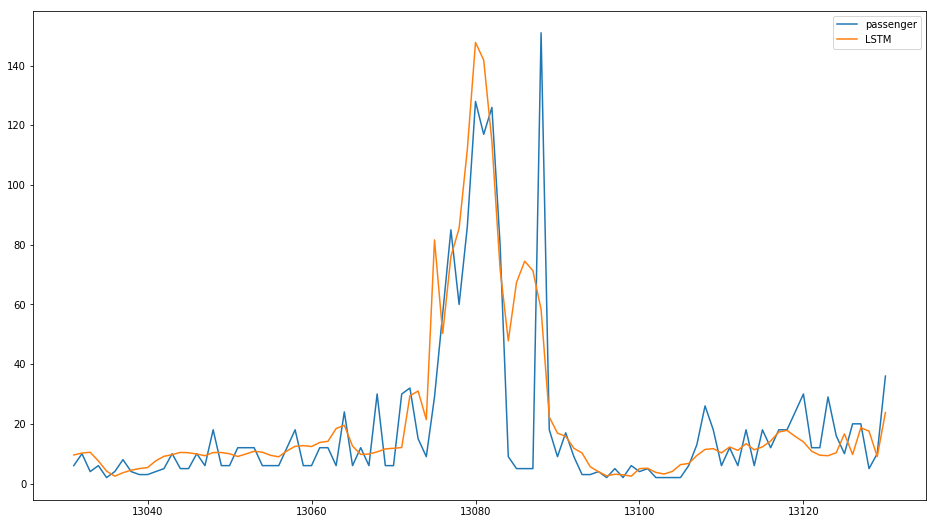

In [35]:
# import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16, 9))
ax =fig.add_subplot(111)

comp_90.plot(ax=ax)
plt.show()